In [2]:
import torch
from ultralytics import YOLO
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))
sys.path.append(os.path.join(os.path.dirname(os.getcwd()),"src"))
from src.loader import AICITY2023TRACK5TEST,readDataFrame
import os
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader 
import tqdm
import cv2 
import pandas as pd
from src.model import initialize_model,decode
import random
import numpy as np

/opt/miniconda3/envs/SYDE675/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
wandb: Currently logged in as: kirtankanani. Use `wandb login --relogin` to force relogin


In [3]:
DATA_DIRECTORY = os.path.join(os.path.dirname(os.getcwd()),"data")
TEST_DATA_DIRECTORY = os.path.join(DATA_DIRECTORY,"aicity2023_track5_test")
TRAIN_DATA_DIRECTORY = os.path.join(DATA_DIRECTORY,"aicity2023_track5",)

VIDEO_TEST_DIRECTORY = os.path.join(TEST_DATA_DIRECTORY, "videos")

IMAGE_VAL_DIRECTORY = os.path.join(TRAIN_DATA_DIRECTORY,"validationImages")
IMAGE_TEST_DIRECTORY = os.path.join(TEST_DATA_DIRECTORY, "testImages")
IMAGE_TRAIN_DIRECTORY = os.path.join(TRAIN_DATA_DIRECTORY,"trainImages")
CROPPED_IMAGE_TRAIN_DIRECTORY = os.path.join(TRAIN_DATA_DIRECTORY,"croppedImages")


LABEL_VAL_DIRECTORY = os.path.join(TRAIN_DATA_DIRECTORY,"valLabels")
LABEL_TEST_DIRECTORY = os.path.join(TEST_DATA_DIRECTORY,"testLabels")

MODEL_PATH = os.path.join(os.path.dirname(os.getcwd()),"src","best_model.pth")


In [149]:
Random_indexes = [random.randint(0,len(os.listdir(IMAGE_TEST_DIRECTORY))) for i in range(9)]
Test_image = os.listdir(IMAGE_TEST_DIRECTORY)

In [82]:
def SingleImageYolo(model,image_directory,test_label_directory):
    results = model([image_directory])
    df = results.pandas().xyxy[0]
    file_name = image_directory.split("/")[-1].split(".")[0]
    df.to_csv(os.path.join(test_label_directory,file_name)+".csv",index = False)

In [84]:
def GenerateAllTheLabels(test_image_directory, test_label_directory):
    
    if not os.path.exists(test_label_directory):
        os.makedirs(test_label_directory)
            
    model = torch.hub.load('ultralytics/yolov5', 'yolov5m', pretrained=True)
    model.classes = [0,3]
    image_lists = os.listdir(test_image_directory)
    for image_path in tqdm.tqdm(image_lists):
        if(image_path.split(".")[-1] != "jpeg"):
            continue
        imagePathFinal = os.path.join(test_image_directory,image_path)
        SingleImageYolo(model,imagePathFinal,test_label_directory)

In [85]:
GenerateAllTheLabels(IMAGE_TEST_DIRECTORY,LABEL_TEST_DIRECTORY)

Using cache found in /Users/kirtankanani/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-4-16 Python-3.8.10 torch-1.9.0.post2 CPU

Fusing layers... 


requirements: /Users/kirtankanani/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients, 48.9 GFLOPs
Adding AutoShape... 
100%|███████████████████████████████████| 19986/19986 [2:25:36<00:00,  2.29it/s]


In [136]:
def GenerateAllTheInferenceData(test_image_directory):
    path=os.path.join(os.getcwd(),"weights","best.pt")
    model = torch.hub.load('ultralytics/yolov5', 'custom',path = path)
    data = {"bb_left":[],"bb_top":[],"bb_width":[],"bb_height":[],"confidence":[],"category":[],"video_id":[],"frame":[]}
    image_paths = os.listdir(test_image_directory)
    with tqdm.tqdm(total = len(image_paths)) as loop:
        for image_path in image_paths:
            image = cv2.imread(os.path.join(test_image_directory,image_path))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            result = model(image)
            video,frame = image_path.split("_")
            frame = frame.split(".")[0]

            for i in result.xyxy[0]:
                data["bb_left"].append(int(i[0].item()))
                data["bb_top"].append(int(i[1].item()))
                data["bb_width"].append(int(i[2].item()- i[0].item()))
                data["bb_height"].append(int(i[3].item()-i[1].item()))
                data["confidence"].append(i[4].item())
                data["category"].append(int(i[5].item()))
                data["video_id"].append(video)
                data["frame"].append(frame)
            loop.update(1)
    
    return data
            

In [137]:
df = GenerateAllTheInferenceData(IMAGE_TEST_DIRECTORY)

Using cache found in /Users/kirtankanani/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-4-16 Python-3.8.10 torch-1.9.0.post2 CPU

Fusing layers... 


requirements: /Users/kirtankanani/.cache/torch/hub/requirements.txt not found, check failed.


Model summary: 212 layers, 20877180 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 
100%|███████████████████████████████████| 19986/19986 [1:28:26<00:00,  3.77it/s]


In [139]:
pd.DataFrame(df).to_csv(os.path.join(TEST_DATA_DIRECTORY,"yolov5mPredictions.csv"))

In [8]:
def GenerateThePredictionAnswers(test_data_directory,image_test_directory,label_test_directory,model_path,save_path):
    testDataset = AICITY2023TRACK5TEST(test_data_directory,image_test_directory,label_test_directory,testValidationFlag=True)
    testLoader = DataLoader(testDataset,batch_size = 1,shuffle=False,collate_fn=testDataset.collate_fn)
    
    model = initialize_model("efficientnet",8,False,False)
    checkpoints = torch.load(model_path)
    model.load_state_dict(checkpoints)
    
    final_labels = []
    softmax = torch.nn.Softmax()
    
    with tqdm.tqdm(total = len(testLoader)) as loop:
        model.eval()
        for index,batch in enumerate(iter(testLoader)):
            images,labels = batch
            prediction = model(images)
            class_predictions = decode(prediction)
            class_predictions = class_predictions.detach().cpu().numpy()
            prediction = softmax(prediction)
            labels["class_predictions_model"] = class_predictions
            labels["confidence"] = torch.max(prediction,dim = 1)[0].detach().numpy()
            final_labels.append(labels)
            loop.update(1)
            break
    
    df = pd.concat(final_labels)
    df.reset_index(drop = True,inplace = True)
    df.to_csv(os.path.join(save_path,"twoModel.csv"))
    
    

In [9]:
labels = GenerateThePredictionAnswers(TEST_DATA_DIRECTORY,IMAGE_TEST_DIRECTORY,LABEL_TEST_DIRECTORY,MODEL_PATH,".") # Run this code on colab

  0%|                                                 | 0/19986 [00:00<?, ?it/s]/var/folders/bt/crfk9c5d2lzd9dqtt8nyxy7c0000gn/T/ipykernel_3562/655193563.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prediction = softmax(prediction)
  0%|                                       | 1/19986 [00:01<8:13:09,  1.48s/it]


In [211]:
path=os.path.join(os.getcwd(),"weights","best.pt")

In [189]:
model = torch.hub.load('ultralytics/yolov5', 'custom',path = path)

Using cache found in /Users/kirtankanani/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-4-16 Python-3.8.10 torch-1.9.0.post2 CPU

Fusing layers... 


requirements: /Users/kirtankanani/.cache/torch/hub/requirements.txt not found, check failed.


Model summary: 212 layers, 20877180 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 


In [190]:
def add_bbox_Image(image,bbounding_box_data):
    """
    This is the function when the bounding box is not normalized and contains
    the top and the bottom corner
    """
    font = cv2.FONT_HERSHEY_TRIPLEX
    fontScale = 1.5
    fontColor = (0, 0, 255)
    labels = {0 : "motorbike",1 : "DHelmet",2 : "DNoHelmet",3 : "P1Helmet",4 : "P1NoHelmet",5 :  "P2Helmet",6: "P2NoHelmet"}
    
        
    for index,bbounding_box in bbounding_box_data.iterrows():
        start_point = (int(bbounding_box["xmin"]),int(bbounding_box["ymin"]))
        end_point = (int(bbounding_box["xmax"]),int(bbounding_box["ymax"]))
        cv2.rectangle(image,start_point,end_point,color=(0,255,0), thickness=2)
        class_text = str(labels[int(bbounding_box["category"])] + " " +str(round(bbounding_box["confidence"],2)))
        class_text_location = (start_point[0] + 5,start_point[1]-15)
        cv2.putText(image,class_text,class_text_location,font,fontScale,fontColor)
        
    return image

In [191]:
def prediction(model,image):
    im = np.copy(image)
    result = model(im)
    df = pd.DataFrame(result.xyxy[0].numpy(),columns = ["xmin","ymin","xmax","ymax","confidence","category"])
    return df

In [192]:
def plots(model,prediction):
    
    fig,ax = plt.subplots(3,3,figsize=(18,10))
    
    index = 0
    for i in range(3):
        for j in range(3):
            image_path = os.path.join(IMAGE_TEST_DIRECTORY,Test_image[Random_indexes[index]])
            video_id,frame = Test_image[Random_indexes[index]].split("_")
            frame = frame.split(".")[0]
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            df = prediction(model,image)
            image = add_bbox_Image(image,df)
            ax[i,j].imshow(image)
            ax[i,j].axis('off')
            ax[i,j].set_title(f"video id:{video_id} frame:{frame}")
            index += 1
            

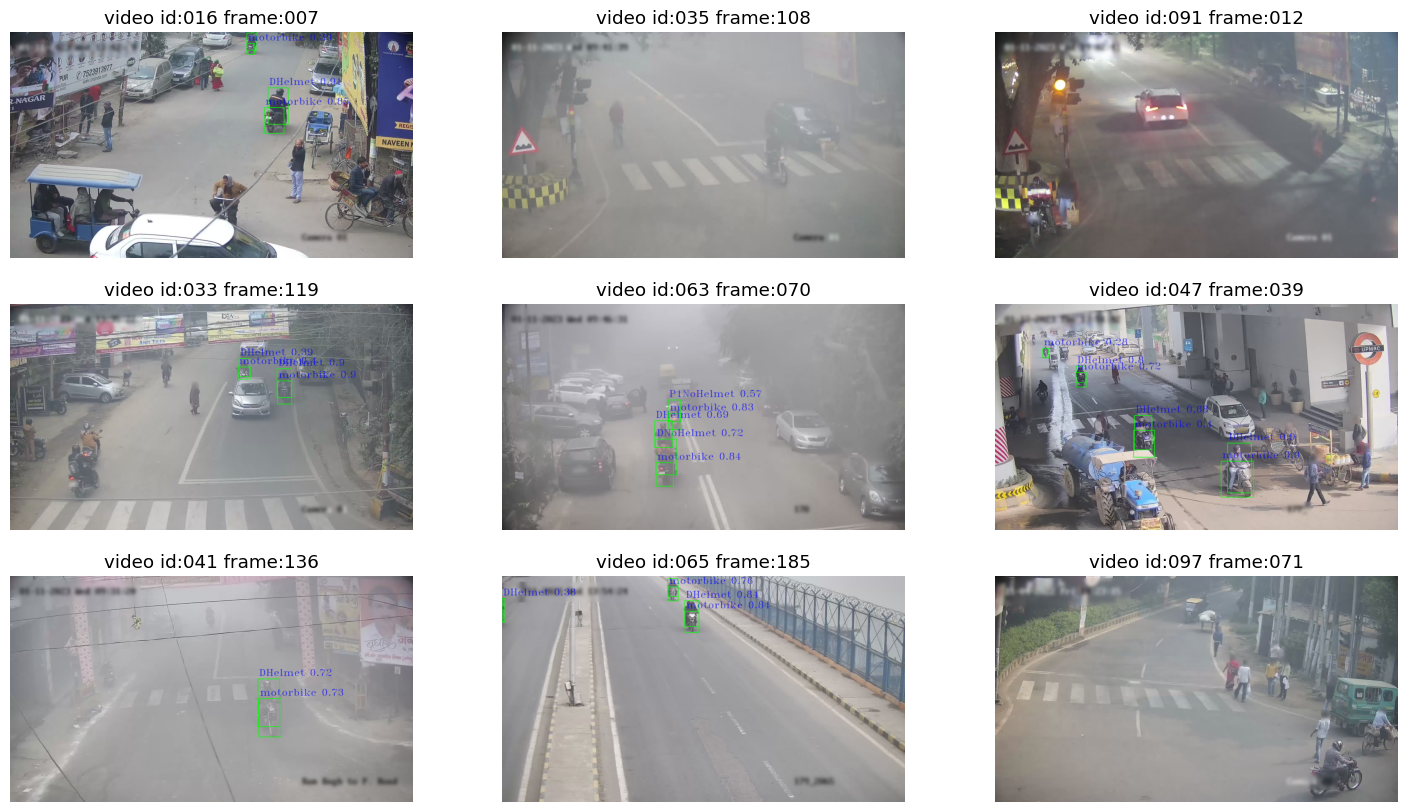

In [193]:
plots(model,prediction)

In [217]:
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5m', pretrained=True)
yolo_model.classes = [0,3]


model = initialize_model("efficientnet",8,True,False)
checkpoints = torch.load(MODEL_PATH)
model.load_state_dict(checkpoints)

Using cache found in /Users/kirtankanani/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-4-16 Python-3.8.10 torch-1.9.0.post2 CPU

Fusing layers... 


requirements: /Users/kirtankanani/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients, 48.9 GFLOPs
Adding AutoShape... 


<All keys matched successfully>

In [218]:
def prediction2(model,image):
    yolo_model,model = model
    im = np.copy(image)
    result = yolo_model(image)
    df = pd.DataFrame(result.xyxy[0].numpy(),columns = ["xmin","ymin","xmax","ymax","confidence","category"])
    final_df = []
    for index,row in df.iterrows():
        croppedImage = image[int(row["ymin"]):int(row["ymax"]),int(row["xmin"]):int(row["xmax"])]
        new_size = (100, 100)
        resized_img = cv2.resize(croppedImage, new_size)
        resized_img = torch.tensor(resized_img,dtype = torch.float)
        resized_img = torch.unsqueeze(torch.permute(resized_img,(2,0,1)),0)
        model.eval()

        predictions = model(resized_img)
        class_prediction = decode(predictions)
        row["category"] = class_prediction.item()
        softmax = torch.nn.Softmax()
        predictions = softmax(predictions)
        row["confidence"] = torch.max(predictions).item()
        if(row["confidence"] < 0.5):
            continue
        final_df.append(row)
    
    return pd.DataFrame(final_df)

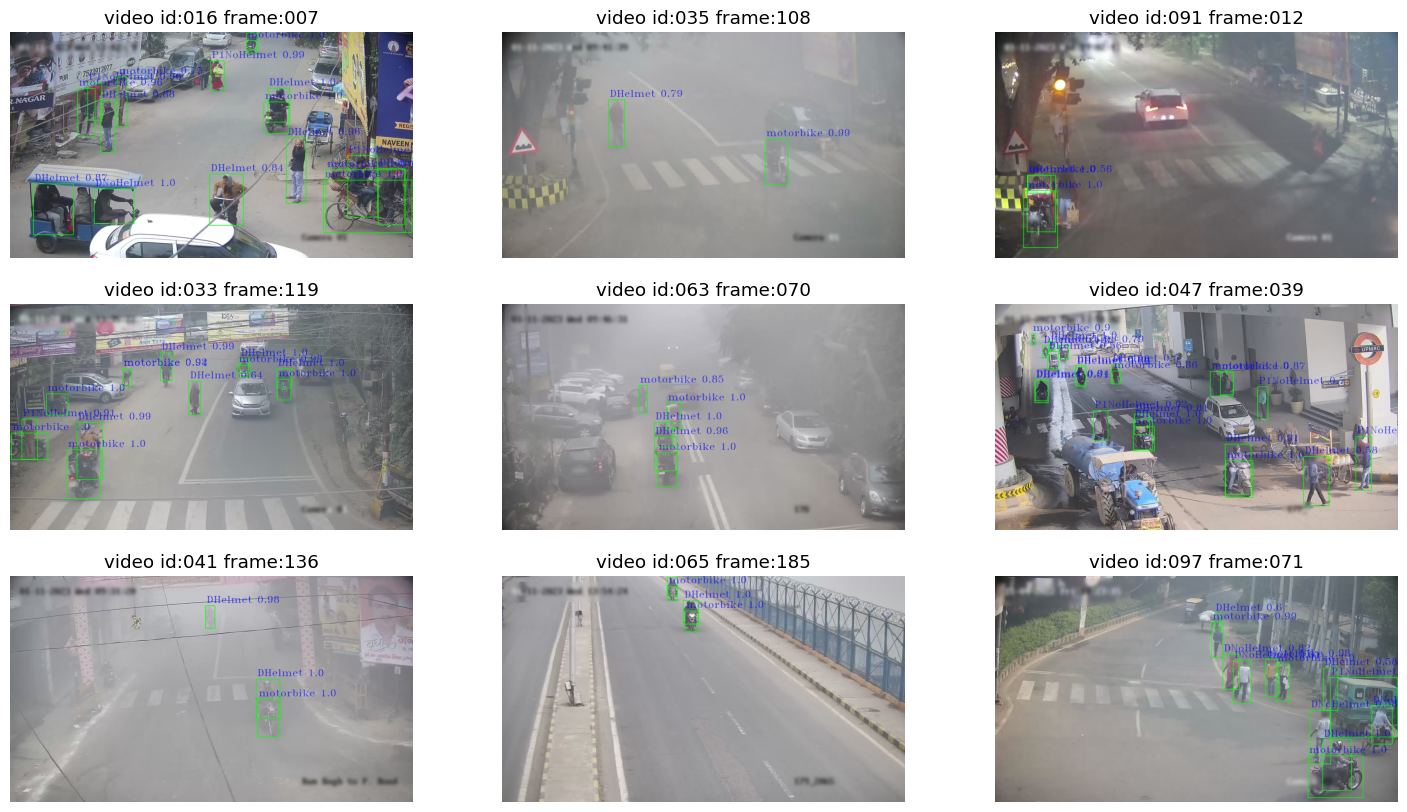

In [219]:
plots((yolo_model,model),prediction2)

# Helmet and No-Helmet

In [6]:
def GenearateCroppedImages(trainDirectory,trainImageDirectory,trainCroppedImageDirectory,X,y):
    images = os.listdir(trainImageDirectory)
    df,_ = readDataFrame(trainDirectory)
    counter = 0
    
    # if not os.path.exists(trainCroppedImageDirectory):
    #     os.makedirs(trainCroppedImageDirectory)

    with tqdm.tqdm(total = df.shape[0]) as loop:
        for index,row in  df.iterrows():
            image_path = os.path.join(trainImageDirectory,row["image_path"])
            image = cv2.imread(os.path.join(trainImageDirectory,image_path))
            start_point = (int(row["bb_left"]),int(row["bb_top"]))
            end_point = (int(row["bb_width"]) + start_point[0],int(row["bb_height"]) + start_point[1])
            image_patch = image[start_point[1]:end_point[1],start_point[0]:end_point[0]]
            new_size = (50, 100)
            resized_img = cv2.resize(image_patch, new_size)
            file_name = row["image_path"].split(".")[0] + "_" + f"{counter:05}"
            X.append([resized_img])
            y.append(row["category"])
            # cv2.imwrite(os.path.join(trainCroppedImageDirectory,file_name)+".jpeg",resized_img)
            # if(counter > 10000):
            #     break
            counter += 1
            loop.update(1)
    return X,y

In [8]:
X_train,y_train = GenearateCroppedImages(TRAIN_DATA_DIRECTORY,IMAGE_TRAIN_DIRECTORY,CROPPED_IMAGE_TRAIN_DIRECTORY,[],[])

100%|████████████████████████████████████████████████████████| 59220/59220 [05:51<00:00, 168.44it/s]


In [9]:
lenofimage = len(X_train)

In [10]:
X_train= np.array(X_train).reshape(lenofimage,-1)

In [11]:
X_train.shape

(59220, 15000)

In [12]:
X_train = X_train/255.0

In [13]:
y_train=np.array(y_train)

In [14]:
y_train.shape

(59220,)

In [ ]:
from sklearn.svm import SVC
svc = SVC(kernel='linear',gamma='auto')
svc.fit(X_train, y_train)

In [ ]:
X_val,y_val = GenearateCroppedImages(TRAIN_DATA_DIRECTORY,IMAGE_VAL_DIRECTORY,CROPPED_IMAGE_TRAIN_DIRECTORY,[],[])

In [ ]:
X_val = np.array(X_val).reshape(lenofimage,-1)
X_val = X_val/255.0
y_val=np.array(y_val)

In [ ]:
y2 = svc.predict(X_val)

In [ ]:
from sklearn.metrics import accuracy_score
print("Accuracy on unknown data is",accuracy_score(y_val,y2))

In [ ]:
from sklearn.metrics import classification_report
print("Accuracy on unknown data is",classification_report(y_val,y2))